In [1]:
#import packages
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans
import datetime

#import data

Products = pd.read_csv('s3://kevinr/Product.csv')

EndUser = pd.read_csv('s3://kevinr/EndUser.csv')

Invoice = pd.read_csv('s3://kevinr/Invoice.csv')

Vendor = pd.read_csv('s3://kevinr/Vendor.csv')

Invoice.head()

COUNTRY_CODE INVOICE_DATE                        INVOICE_ID  INVOICE_LINE  \
0           UK   07/15/2019  E5ED03155812D08AF95C0DE6C6CFC756             1   
1           UK   06/06/2019  060AFA0DDB5F61AE58689DE4E1C45F66             1   
2           UK   04/04/2019  95F78CBA7E223D0441DBE5EC9139C534             1   
3           UK   02/20/2019  14104E4FCCE6B2BF8A3CC8321DC1B5AE             1   
4           UK   11/07/2019  1176EAEA7C94F29A0335D9A5EE9D2A0D             1   

                         PRODUCT_ID  UNITE_PRICE_$  QUANTITY_ORDERED  \
0  74B2CFB8460D047F00CEC531319C7768    3285.863338                 6   
1  9A5264F9ED8507F6F31112E24917452D     418.152176                 1   
2  42A3AE06A8DC14FF62FDA90A55292CAA      60.578612                 1   
3  F5B5DB9152AEE5BC633DEF60AC30203D      69.704712                 6   
4  59343B86E5B56460844F92C4A87ED4D1     566.165348                 1   

                        END_USER_ID  
0  68D292A10256DB24405C56738F34D976  
1  4B39A21A1DD7881D4E165B9E90A4B831  
2  BE572735EA42E603C64667A191FAB9F6  
3  E781130707853D0407533FC5433CF0BB  
4  B9B2476B6EBE1C6657CACC1C836BDF6C

In [2]:
#data

I = Invoice.groupby('END_USER_ID')['UNITE_PRICE_$'].apply(sum)
J = pd.DataFrame({'END_USER_ID':I.index, 'TOTAL_SPENT':I.values})
Invoice = pd.merge(Invoice, J,on='END_USER_ID')

data = pd.merge(Products, Vendor,on='VENDOR_ID')
data = pd.merge(data, Invoice,on='PRODUCT_ID')
data = pd.merge(data, EndUser,on='END_USER_ID')
data.head()



Unnamed: 0_x COUNTRY_CODE_x                        PRODUCT_ID  \
0             0             UK  9E801BBAA766E00E05FBEFC26A8625A9   
1           312             UK  B74D9D7359A182AACA02F9152266DECA   
2           312             UK  B74D9D7359A182AACA02F9152266DECA   
3           312             UK  B74D9D7359A182AACA02F9152266DECA   
4           813             UK  8678A0159CC487E3B6F855B2B3A6C75C   

                                        PRODUCT_DECS    PRODUCT_CAT  \
0         MULTI ROLLER SCALE LAPTOP BAG 15.6IN BLACK    ACCESSORIES   
1                ACTIVE LAPTOP BACKPACK 15.6IN BLACK    ACCESSORIES   
2                ACTIVE LAPTOP BACKPACK 15.6IN BLACK    ACCESSORIES   
3                ACTIVE LAPTOP BACKPACK 15.6IN BLACK    ACCESSORIES   
4  PIN POINT PRESENTATION POINTER W/INTEGRATED LA...  INPUT DEVICES   

      PRODUCT_SUBCAT                         VENDOR_ID  Unnamed: 0_y  \
0      CARRYING CASE  9D6D09A057BD9EE705148D760EB8FE6C           665   
1      CARRYING CASE  9D6D09A057BD9EE705148D760EB8FE6C           665   
2      CARRYING CASE  9D6D09A057BD9EE705148D760EB8FE6C           665   
3      CARRYING CASE  9D6D09A057BD9EE705148D760EB8FE6C           665   
4  INPUT DEVICE ACCS  9D6D09A057BD9EE705148D760EB8FE6C           665   

  COUNTRY_CODE_y VENDOR_NAME  ...   TOTAL_SPENT Unnamed: 0 COUNTRY_CODE_y  \
0             UK      DICOTA  ...  3.621332e+07      29029             UK   
1             UK      DICOTA  ...  3.621332e+07      29029             UK   
2             UK      DICOTA  ...  3.621332e+07      29029             UK   
3             UK      DICOTA  ...  3.621332e+07      29029             UK   
4             UK      DICOTA  ...  3.621332e+07      29029             UK   

    STATE Business_CAT_LEVEL_1  Business_CAT_LEVEL_2  \
0  LONDON             Services     Business Services   
1  LONDON             Services     Business Services   
2  LONDON             Services     Business Services   
3  LONDON             Services     Business Services   
4  LONDON             Services     Business Services   

                         Business_CAT_LEVEL_3  EMPLOYEES_BIN ANNUAL_SALES  \
0  Computer Programming, Data Processing, And        UNKNOWN  210639038.0   
1  Computer Programming, Data Processing, And        UNKNOWN  210639038.0   
2  Computer Programming, Data Processing, And        UNKNOWN  210639038.0   
3  Computer Programming, Data Processing, And        UNKNOWN  210639038.0   
4  Computer Programming, Data Processing, And        UNKNOWN  210639038.0   

   YEAR_STARTED  
0          2006  
1          2006  
2          2006  
3          2006  
4          2006  

[5 rows x 29 columns]

In [3]:
#bin annual sales
pd.qcut(data['ANNUAL_SALES'], q=3)

0          (73842408.0, 278397000000.0]
1          (73842408.0, 278397000000.0]
2          (73842408.0, 278397000000.0]
3          (73842408.0, 278397000000.0]
4          (73842408.0, 278397000000.0]
                       ...             
1127005              (0.999, 2111946.0]
1127006                             NaN
1127007                             NaN
1127008              (0.999, 2111946.0]
1127009              (0.999, 2111946.0]
Name: ANNUAL_SALES, Length: 1127010, dtype: category
Categories (3, interval[float64]): [(0.999, 2111946.0] < (2111946.0, 73842408.0] < (73842408.0, 278397000000.0]]

In [4]:
data['total_spent_bin'] = pd.qcut(data['TOTAL_SPENT'], q=3)
data['Annual_Sales_bin'] = pd.qcut(data['ANNUAL_SALES'], q=3)

In [5]:
d2= data.drop_duplicates(subset = ['PRODUCT_ID','END_USER_ID'], keep = 'last')

In [6]:
d4= data.drop_duplicates(subset = ['VENDOR_ID','END_USER_ID'], keep = 'last')

In [7]:
## get a list of all users and the products they purchased
productsPerUser = d2.groupby('END_USER_ID')['PRODUCT_ID'].apply(list)
PPU = pd.DataFrame({'END_USER_ID':productsPerUser.index, 'Products':productsPerUser.values})
PPU

END_USER_ID  \
0       000132B479F0F56A47249E8093C7C180   
1       00017609D0C74E6CE907CFF9111F412E   
2       0001CCEEC0E80598BB94ACC3247E7710   
3       000242D514CE9634091A121F64F972FB   
4       0002A1EF533B2E30C136BD9E0B3C7F90   
...                                  ...   
148458  FFFEAEB6AADD794DF0A99CD82E0289FB   
148459  FFFEB6ACEABBA3F95BB5DE57828412DF   
148460  FFFF75E2F481CE59842E7139776CAAAD   
148461  FFFFACBEEAEC71689FFABD9FBEC05EB4   
148462  FFFFC15BBBB8DA626CF517D97A726CF8   

                                                 Products  
0                      [D6E579C0D0EFA6C5405370CE1FB0D3F9]  
1                      [CE291FDC88ED34CE85AE2B7D9788CB50]  
2       [950564EBBBD448E0C3ACE0B1DDEE72CE, EB1F0052603...  
3       [CA12E9CD8273215CF1AB049DA2A1059F, DB9BCE4AC01...  
4       [08CFE495D892BF022C6301BAD41DEA20, D075CB4D4A1...  
...                                                   ...  
148458                 [595CAAD82A96B4503DD83350025BB9FD]  
148459                 [FFB433CAF9AD532AFAFD4D772C0E8BD2]  
148460                 [243492F4AEA4B5F0CA699E5F3E349A50]  
148461  [92FF572DF06ADB5A20ED3E742610EAB9, 8BB932FC0CC...  
148462                 [E331C5B2AC95B8F2A32E08211B0DA350]  

[148463 rows x 2 columns]

In [8]:
VendorPerUser = d4.groupby("END_USER_ID")["VENDOR_ID"].apply(list)
VPU= pd.DataFrame({'END_USER_ID':VendorPerUser.index, 'Vendor':VendorPerUser.values})
VPU

END_USER_ID  \
0       000132B479F0F56A47249E8093C7C180   
1       00017609D0C74E6CE907CFF9111F412E   
2       0001CCEEC0E80598BB94ACC3247E7710   
3       000242D514CE9634091A121F64F972FB   
4       0002A1EF533B2E30C136BD9E0B3C7F90   
...                                  ...   
148458  FFFEAEB6AADD794DF0A99CD82E0289FB   
148459  FFFEB6ACEABBA3F95BB5DE57828412DF   
148460  FFFF75E2F481CE59842E7139776CAAAD   
148461  FFFFACBEEAEC71689FFABD9FBEC05EB4   
148462  FFFFC15BBBB8DA626CF517D97A726CF8   

                                                   Vendor  
0                      [7ED5AB2BFA4C55BD87D00B17B4A4D970]  
1                      [C76DA52B2FCE23F1949FAAC059A27E44]  
2       [A4190183C76E071BEE5E74B2629C637F, 368A7CB85E9...  
3                      [ADFBBD3C396430AD163CC304E95FE5A7]  
4       [ADFBBD3C396430AD163CC304E95FE5A7, F2385A685B2...  
...                                                   ...  
148458                 [300D8636ADA68AAA8F7D2494D70BC330]  
148459                 [11CA995A4746A5BB9A6C08B284DC8DA0]  
148460                 [300D8636ADA68AAA8F7D2494D70BC330]  
148461  [81D15DF54B2371844A5F42485E6B4C33, 6B6A40374A4...  
148462                 [C1E28EA83D439828EB751EC2F69BF0E8]  

[148463 rows x 2 columns]

In [9]:
d3 = data[['END_USER_ID','total_spent_bin']].drop_duplicates(subset = ['END_USER_ID','total_spent_bin'])
d3

END_USER_ID               total_spent_bin
0        0DF9912E0B03F1B29912720999323F3C    (709053.885, 48269844.737]
15892    A0FDB4C93FD46033CC782AA1DD83D78E    (709053.885, 48269844.737]
23333    4FD0E289560F5AF8CDF2664A68FDAF12    (709053.885, 48269844.737]
26010    FBEFFA3FE060AF057CEA1574CD25DF20         (7279.18, 709053.885]
26235    D35367187F19EF4EEB3677869177E469         (7279.18, 709053.885]
...                                   ...                           ...
1127005  B1F5EFF9FF2A89EE6932BBC293D2E7AB  (9.001000000000001, 7279.18]
1127006  53F5AA6A5F01D9362137FA674BA9AF8C  (9.001000000000001, 7279.18]
1127007  107FE731E5F1ECD71AFEEA7317FC1106  (9.001000000000001, 7279.18]
1127008  4C22DB3BC32A03A66C6690A7F08DA42E  (9.001000000000001, 7279.18]
1127009  597D3A4358FD742F4942A71387B6032B  (9.001000000000001, 7279.18]

[148463 rows x 2 columns]

In [10]:

#frames = [PPU, VPU, SPU]

result = pd.merge(PPU, VPU, on='END_USER_ID')
#result = pd.merge(result, SPU, on='END_USER_ID')
result = pd.merge(result, EndUser, on='END_USER_ID')

result['Annual_Sales_bin'] = pd.qcut(result['ANNUAL_SALES'], q=3)

result = pd.merge(result, d3, on='END_USER_ID')
result

END_USER_ID  \
0       000132B479F0F56A47249E8093C7C180   
1       00017609D0C74E6CE907CFF9111F412E   
2       0001CCEEC0E80598BB94ACC3247E7710   
3       000242D514CE9634091A121F64F972FB   
4       0002A1EF533B2E30C136BD9E0B3C7F90   
...                                  ...   
148458  FFFEAEB6AADD794DF0A99CD82E0289FB   
148459  FFFEB6ACEABBA3F95BB5DE57828412DF   
148460  FFFF75E2F481CE59842E7139776CAAAD   
148461  FFFFACBEEAEC71689FFABD9FBEC05EB4   
148462  FFFFC15BBBB8DA626CF517D97A726CF8   

                                                 Products  \
0                      [D6E579C0D0EFA6C5405370CE1FB0D3F9]   
1                      [CE291FDC88ED34CE85AE2B7D9788CB50]   
2       [950564EBBBD448E0C3ACE0B1DDEE72CE, EB1F0052603...   
3       [CA12E9CD8273215CF1AB049DA2A1059F, DB9BCE4AC01...   
4       [08CFE495D892BF022C6301BAD41DEA20, D075CB4D4A1...   
...                                                   ...   
148458                 [595CAAD82A96B4503DD83350025BB9FD]   
148459                 [FFB433CAF9AD532AFAFD4D772C0E8BD2]   
148460                 [243492F4AEA4B5F0CA699E5F3E349A50]   
148461  [92FF572DF06ADB5A20ED3E742610EAB9, 8BB932FC0CC...   
148462                 [E331C5B2AC95B8F2A32E08211B0DA350]   

                                                   Vendor  Unnamed: 0  \
0                      [7ED5AB2BFA4C55BD87D00B17B4A4D970]       65309   
1                      [C76DA52B2FCE23F1949FAAC059A27E44]       12548   
2       [A4190183C76E071BEE5E74B2629C637F, 368A7CB85E9...       92729   
3                      [ADFBBD3C396430AD163CC304E95FE5A7]       68297   
4       [ADFBBD3C396430AD163CC304E95FE5A7, F2385A685B2...       86623   
...                                                   ...         ...   
148458                 [300D8636ADA68AAA8F7D2494D70BC330]       95470   
148459                 [11CA995A4746A5BB9A6C08B284DC8DA0]      125925   
148460                 [300D8636ADA68AAA8F7D2494D70BC330]       44297   
148461  [81D15DF54B2371844A5F42485E6B4C33, 6B6A40374A4...       45595   
148462                 [C1E28EA83D439828EB751EC2F69BF0E8]      124977   

       COUNTRY_CODE           STATE   Business_CAT_LEVEL_1  \
0                UK             NaN               Services   
1                UK         BELFAST        Wholesale Trade   
2                UK      DERBYSHIRE           Retail Trade   
3                UK        CHESHIRE           Retail Trade   
4                UK          SURREY               Services   
...             ...             ...                    ...   
148458           UK            KENT               Services   
148459           UK  WEST YORKSHIRE               Services   
148460           UK       HAMPSHIRE  Public Administration   
148461           UK   HERTFORDSHIRE               Services   
148462           UK      DERBYSHIRE               Services   

                     Business_CAT_LEVEL_2  \
0                          Legal Services   
1           Wholesale Trade-durable Goods   
2                    Miscellaneous Retail   
3                    Miscellaneous Retail   
4                          Legal Services   
...                                   ...   
148458  Amusement And Recreation Services   
148459                    Social Services   
148460     Nonclassifiable Establishments   
148461                  Business Services   
148462               Educational Services   

                              Business_CAT_LEVEL_3 EMPLOYEES_BIN  \
0                                   Legal Services           <20   
1               Machinery, Equipment, And Supplies           <20   
2          Retail Stores, Not Elsewhere Classified       UNKNOWN   
3                               Nonstore Retailers           <20   
4                                   Legal Services           <20   
...                                            ...           ...   
148458      Miscellaneous Amusement And Recreation           <20   
148459       Individual And Family Social Services       100

In [11]:
#result[result.END_USER_ID == '0002A1EF533B2E30C136BD9E0B3C7F90']


In [12]:
#get accurcies
#random sample
#accurcies = pd.read_csv('s3://kevinr/sample.csv')

#build graph

#accurcies
#accurcies["Accuracy"] = accurcies["UserID"].apply(lambda x: getAccuracy(x))
#accurcies

In [14]:
#sample = accurcies.UserID.tolist()
#sample

In [15]:
bs = data.groupby('END_USER_ID')['TOTAL_SPENT'].unique()
big = pd.DataFrame({'User':bs.index, 'Spent':bs.values})
big = big.sort_values(['Spent'], ascending=False).head(300)

## sample top 300 biggest spending customers

sample = big.User.tolist()

sample

['1B687BB46A12C38B38F7770CEADC72B7',
 '0DF9912E0B03F1B29912720999323F3C',
 '12FCE09D18CD0DD9A9A164BECB8456A0',
 '289CEEF05EDEB05B2D6FB02D7C20B6D5',
 'D8931ED111FD020D02EB20FA71CF55EB',
 '18ED49A1CBA4E9CE96F1212E78B10D04',
 '925EFFA0882BB778382EBD65F8DEBB14',
 '336D42B71A053A221B7C4D6456D2F50B',
 '7D1C583D275E7CC9C94DE0A9B82AA2F8',
 '4FD0E289560F5AF8CDF2664A68FDAF12',
 'ACA9B42B12A5A9786A2127EA47D75471',
 'F2CCC2975F1C9E69BA5B630675A3F9C0',
 '8C5A07E9984142E44F4FD0AADFC8D202',
 'A0FDB4C93FD46033CC782AA1DD83D78E',
 'B38A91FC2ED3C7E25CB9846674C39945',
 '4874F478AC2ECF6F173C43549A70FBD7',
 '60072D5CD2630FB5044952B966DB7C81',
 '02B9DE307FD181AC051C5FCC603550D4',
 'B24848B742B40286F6743280437B221F',
 'F1AE4E7FB6890A282D141C789F136584',
 'BE76DE046F08EF15842F3422F2DEA0AD',
 'FA265725798287F30ECDA6084A186A0F',
 '6CC27D3B00482FFC8B45EAA5C1377325',
 '5BD39A7D806527C260139410A1416821',
 '206108913DCF05D5EC1A44E621545163',
 'CD1DC7EBEF0CA50FA01881EC0897207A',
 'ED0E0E9ECCFD3EAD449597F7D6E46EE5',
 

In [16]:
accurcies = pd.DataFrame({'UserID': sample})
accurcies

UserID
0    1B687BB46A12C38B38F7770CEADC72B7
1    0DF9912E0B03F1B29912720999323F3C
2    12FCE09D18CD0DD9A9A164BECB8456A0
3    289CEEF05EDEB05B2D6FB02D7C20B6D5
4    D8931ED111FD020D02EB20FA71CF55EB
..                                ...
295  464EE6BB5C1545312610EAC1D5695077
296  EA26AEB8BBC397B7FAE9491D47475B22
297  191AF2FE692C1805427097FF059F3ECE
298  FA2BD153A3A085405ECD12D94DCA9D47
299  87575DE7B6CB3281FD3EF6C26722C8BD

[300 rows x 1 columns]

In [17]:
# remove products from sample customers
#this will take a long time to run
result1 = result
for i, row in result1.iterrows():
    if row['END_USER_ID'] in sample:
        result1.at[i,'Products']= 0
        print(i)
result1


173
652
809
1601
2050
2257
2358
2737
2963
3492
4141
4355
4626
5660
5924
6267
6523
7336
7987
10182
10933
11537
11648
12967
14452
14552
14820
15143
15417
15545
15925
16257
16641
16647
17544
17774
18714
19754
19950
20149
20563
20775
21678
22358
22605
23037
23389
23426
24043
24077
24137
24899
24927
26363
26764
27208
27487
27695
28038
28608
29147
29709
30038
31188
31598
32600
34518
34950
35067
35325
36864
37425
37712
38486
38955
39103
39320
39713
39810
40029
40508
40528
40603
40675
40790
40991
41450
41570
41809
43879
44158
45042
45630
46026
46039
47080
48330
48814
49067
49235
50040
50123
50529
51037
51321
51941
53042
53365
54036
55056
55146
55189
55409
55479
56089
56513
57014
57488
58171
58782
58836
59132
59399
59726
62892
64997
65196
65629
67297
67413
67556
68100
68129
68492
69165
70085
70743
71493
71893
72402
73501
74311
74779
75585
76456
77446
78294
79366
79401
81020
81258
81315
81707
81744
81896
82148
82451
82651
82680
82806
83368
84813
85708
85821
86574
86926
86971
87016
87036
87052
87

END_USER_ID  \
0       000132B479F0F56A47249E8093C7C180   
1       00017609D0C74E6CE907CFF9111F412E   
2       0001CCEEC0E80598BB94ACC3247E7710   
3       000242D514CE9634091A121F64F972FB   
4       0002A1EF533B2E30C136BD9E0B3C7F90   
...                                  ...   
148458  FFFEAEB6AADD794DF0A99CD82E0289FB   
148459  FFFEB6ACEABBA3F95BB5DE57828412DF   
148460  FFFF75E2F481CE59842E7139776CAAAD   
148461  FFFFACBEEAEC71689FFABD9FBEC05EB4   
148462  FFFFC15BBBB8DA626CF517D97A726CF8   

                                                 Products  \
0                      [D6E579C0D0EFA6C5405370CE1FB0D3F9]   
1                      [CE291FDC88ED34CE85AE2B7D9788CB50]   
2       [950564EBBBD448E0C3ACE0B1DDEE72CE, EB1F0052603...   
3       [CA12E9CD8273215CF1AB049DA2A1059F, DB9BCE4AC01...   
4       [08CFE495D892BF022C6301BAD41DEA20, D075CB4D4A1...   
...                                                   ...   
148458                 [595CAAD82A96B4503DD83350025BB9FD]   
148459                 [FFB433CAF9AD532AFAFD4D772C0E8BD2]   
148460                 [243492F4AEA4B5F0CA699E5F3E349A50]   
148461  [92FF572DF06ADB5A20ED3E742610EAB9, 8BB932FC0CC...   
148462                 [E331C5B2AC95B8F2A32E08211B0DA350]   

                                                   Vendor  Unnamed: 0  \
0                      [7ED5AB2BFA4C55BD87D00B17B4A4D970]       65309   
1                      [C76DA52B2FCE23F1949FAAC059A27E44]       12548   
2       [A4190183C76E071BEE5E74B2629C637F, 368A7CB85E9...       92729   
3                      [ADFBBD3C396430AD163CC304E95FE5A7]       68297   
4       [ADFBBD3C396430AD163CC304E95FE5A7, F2385A685B2...       86623   
...                                                   ...         ...   
148458                 [300D8636ADA68AAA8F7D2494D70BC330]       95470   
148459                 [11CA995A4746A5BB9A6C08B284DC8DA0]      125925   
148460                 [300D8636ADA68AAA8F7D2494D70BC330]       44297   
148461  [81D15DF54B2371844A5F42485E6B4C33, 6B6A40374A4...       45595   
148462                 [C1E28EA83D439828EB751EC2F69BF0E8]      124977   

       COUNTRY_CODE           STATE   Business_CAT_LEVEL_1  \
0                UK             NaN               Services   
1                UK         BELFAST        Wholesale Trade   
2                UK      DERBYSHIRE           Retail Trade   
3                UK        CHESHIRE           Retail Trade   
4                UK          SURREY               Services   
...             ...             ...                    ...   
148458           UK            KENT               Services   
148459           UK  WEST YORKSHIRE               Services   
148460           UK       HAMPSHIRE  Public Administration   
148461           UK   HERTFORDSHIRE               Services   
148462           UK      DERBYSHIRE               Services   

                     Business_CAT_LEVEL_2  \
0                          Legal Services   
1           Wholesale Trade-durable Goods   
2                    Miscellaneous Retail   
3                    Miscellaneous Retail   
4                          Legal Services   
...                                   ...   
148458  Amusement And Recreation Services   
148459                    Social Services   
148460     Nonclassifiable Establishments   
148461                  Business Services   
148462               Educational Services   

                              Business_CAT_LEVEL_3 EMPLOYEES_BIN  \
0                                   Legal Services           <20   
1               Machinery, Equipment, And Supplies           <20   
2          Retail Stores, Not Elsewhere Classified       UNKNOWN   
3                               Nonstore Retailers           <20   
4                                   Legal Services           <20   
...                                            ...           ...   
148458      Miscellaneous Amusement And Recreation           <20   
148459       Individual And Family Social Services       100

In [18]:
result1[result1.END_USER_ID == '567563D080B2DF33956E7C113EF42359']


END_USER_ID                            Products  \
49948  567563D080B2DF33956E7C113EF42359  [0DB8A742896CA03F72EC01780744044B]   

                                   Vendor  Unnamed: 0 COUNTRY_CODE     STATE  \
49948  [300D8636ADA68AAA8F7D2494D70BC330]       69159           UK  SOMERSET   

      Business_CAT_LEVEL_1                               Business_CAT_LEVEL_2  \
49948         Construction  Building Construction General Contractors And ...   

                           Business_CAT_LEVEL_3 EMPLOYEES_BIN  ANNUAL_SALES  \
49948  General Building Contractors-residential           <20       39066.0   

       YEAR_STARTED   Annual_Sales_bin               total_spent_bin  
49948             0  (0.999, 233044.0]  (9.001000000000001, 7279.18]

In [19]:
result1[result1.END_USER_ID == '1B687BB46A12C38B38F7770CEADC72B7']

END_USER_ID Products  \
15925  1B687BB46A12C38B38F7770CEADC72B7        0   

                                                  Vendor  Unnamed: 0  \
15925  [9D6D09A057BD9EE705148D760EB8FE6C, D884DD6EF46...       15908   

      COUNTRY_CODE            STATE Business_CAT_LEVEL_1 Business_CAT_LEVEL_2  \
15925           UK  BUCKINGHAMSHIRE             Services    Business Services   

                             Business_CAT_LEVEL_3 EMPLOYEES_BIN  ANNUAL_SALES  \
15925  Computer Programming, Data Processing, And       UNKNOWN  1.260471e+09   

       YEAR_STARTED             Annual_Sales_bin             total_spent_bin  
15925          1993  (2219646.0, 278397000000.0]  (709053.885, 48269844.737]

In [20]:
#!{sys.executable} -m pip install networkx

In [21]:


import networkx as nx
import time

# Load the graph by adding nodes and edges

G = nx.Graph(label="END_USER_ID")
start_time = time.time()
for i, rowi in result1.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    #G.add_node(rowi['name'],key=rowi['id'],label="name",mtype=rowi['category'],rating=rowi['rating'])
    element1 = rowi['END_USER_ID']
    G.add_node(element1,label="USER")
    G.add_edge(rowi['END_USER_ID'], element1, label="USER")
        
    element2 = rowi['STATE']
    G.add_node(element2,label="STATE")
    G.add_edge(rowi['END_USER_ID'], element2, label="STATE")
    
    element3 = rowi['Business_CAT_LEVEL_1']
    G.add_node(element3,label="CATL1")
    G.add_edge(rowi['END_USER_ID'], element3, label="CATL1")
    
    element4 = rowi['Business_CAT_LEVEL_2']
    G.add_node(element4,label="CATL2")
    G.add_edge(rowi['END_USER_ID'], element4, label="CATL2")
    
    element5 = rowi['Business_CAT_LEVEL_3']
    G.add_node(element5,label="CATL3")
    G.add_edge(rowi['END_USER_ID'], element5, label="CATL3")
    
    element6 = rowi['EMPLOYEES_BIN']
    G.add_node(element6,label="BIN")
    G.add_edge(rowi['END_USER_ID'], element6, label="BIN")
    
    element7 = rowi['total_spent_bin']
    G.add_node(element7,label="TOTAL")
    G.add_edge(rowi['END_USER_ID'], element7, label="TOTAL")
    
    element8 = rowi['Products']
    if element8 != 0:
        for j in element8:
            G.add_node(j,label="PRODUCT")
            G.add_edge(rowi['END_USER_ID'], j, label="PRODUCT")
        
    element9 = rowi['Vendor']
    for k in element9:
        G.add_node(k,label="VENDOR")
        G.add_edge(rowi['END_USER_ID'], k, label="VENDOR")
        
    element10 = rowi['Annual_Sales_bin']
    G.add_node(element10,label="ANNUAL")
    G.add_edge(rowi['END_USER_ID'], element10, label="ANNUAL")
    
    
    #indices = find_similar(tfidf, i, top_n = 5)
    #snode="Sim("+rowi['END_USER_ID'][:15].strip()+")"        
    #G.add_node(snode,label="SIMILAR")
    #G.add_edge(rowi['END_USER_ID'], snode, label="SIMILARITY")
    #for element in indices:
    #    G.add_edge(snode, Products['END_USER_ID'].loc[element], label="SIMILARITY")
    

print(" finish -- {} seconds --".format(time.time() - start_time))

 iter 0 -- 0.3368351459503174 seconds --
 iter 1000 -- 0.5141072273254395 seconds --
 iter 2000 -- 0.689335823059082 seconds --
 iter 3000 -- 0.8639881610870361 seconds --
 iter 4000 -- 1.0389881134033203 seconds --
 iter 5000 -- 1.2115116119384766 seconds --
 iter 6000 -- 1.3876309394836426 seconds --
 iter 7000 -- 1.562199592590332 seconds --
 iter 8000 -- 1.7393217086791992 seconds --
 iter 9000 -- 1.909179449081421 seconds --
 iter 10000 -- 2.0844671726226807 seconds --
 iter 11000 -- 2.2563366889953613 seconds --
 iter 12000 -- 2.429305076599121 seconds --
 iter 13000 -- 2.599419116973877 seconds --
 iter 14000 -- 2.769195318222046 seconds --
 iter 15000 -- 2.9412872791290283 seconds --
 iter 16000 -- 3.1216037273406982 seconds --
 iter 17000 -- 3.295137643814087 seconds --
 iter 18000 -- 3.4752769470214844 seconds --
 iter 19000 -- 3.646132469177246 seconds --
 iter 20000 -- 3.8160834312438965 seconds --
 iter 21000 -- 3.9879467487335205 seconds --
 iter 22000 -- 4.16109943389892

In [22]:
#Function to combine the edges and nodes for plotting
import matplotlib.pyplot as plt

def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):
            sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="USER":
            colors.append('yellow')
        elif G.nodes[e]['label']=="STATE":
            colors.append('red')
        elif G.nodes[e]['label']=="CATL1":
            colors.append('green')
        elif G.nodes[e]['label']=="CATL2":
            colors.append('pink')
        elif G.nodes[e]['label']=="CATL3":
            colors.append('orange')
        elif G.nodes[e]['label']=="BIN":
            colors.append('purple')
        elif G.nodes[e]['label']=="TOTAL":
            colors.append('brown')
        elif G.nodes[e]['label']=="PRODUCT":
            colors.append('blue')
        elif G.nodes[e]['label']=="VENDOR":
            colors.append('black')
        elif G.nodes[e]['label']=="ANNUAL":
            colors.append('cyan')



            
    plt.figure(figsize = (25,20))
    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors, node_size=900)
    plt.show()

In [23]:
import math as math
#Function to calculate similiarity between 2 users
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="USER":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    USER=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        USER.append(key)
        weight.append(w)
    #ratings = list(np.float_(ratings))
    #recommendation = pd.Dataframe(data=np.array(weight),index=products)
    #recommendation = pd.DataFrame(data=np.array(weight),columns=["products","rating"])
    #recommendation.to_frame()
    d = {"Name": USER, "Closeness": weight}
    recommendation = pd.DataFrame(d)
    recommendation.sort_values(by= ["Closeness"], inplace=True,ascending=False)
    recommendation = recommendation.head(5)
    return recommendation;

In [24]:
# test reccomendations based on users
recommendation = get_recommendation("3062445D06E69CED2A2EEF8E35169B88")
print("*"*40+"\n Recommendation for '3062445D06E69CED2A2EEF8E35169B88'\n"+"*"*40)
print(recommendation)
recommendation2 = get_recommendation("5FF24AF43D4A1B8367498FE3D09E2A0C")
print("*"*40+"\n Recommendation for '5FF24AF43D4A1B8367498FE3D09E2A0C'\n"+"*"*40)
print(recommendation2)

****************************************
 Recommendation for '3062445D06E69CED2A2EEF8E35169B88'
****************************************
                                   Name  Closeness
16934  F8B283D3C56FF8873CCC4B175569E199   0.988539
6449   5652E6746AD7AD34B4A3FA217649339A   0.969583
10299  91E9E26442E3A4E7B5488EBFDC26361D   0.969583
14176  CF46B7B14A2C4936AD4732F3B608AE0D   0.923439
26374  2141BB90B9C31D16A3409FBEBCEF8EE3   0.885680
****************************************
 Recommendation for '5FF24AF43D4A1B8367498FE3D09E2A0C'
****************************************
                                   Name  Closeness
4510   584FF13C11F52A7C68F8AFE3A563CD73   2.475661
43077  BF7D150EC39DDAD9E8D0611CE869648D   2.339418
36769  97E21BA7CF9ED957953E8323A498ECDD   2.050019
56121  A11DDD0B47357A0438C812B29951F660   2.013992
42852  BDF83029B0D4768905D22C76F25B19FC   2.011315


In [25]:
#Close users search in PPU 
#Product Recommendation
def productRec(UserID, test):
    recommendation = get_recommendation(UserID)
    r = recommendation.Name.tolist()

    y = PPU[PPU['END_USER_ID'].isin(r)]

    v = y.Products.tolist()


    flat_list = []
    for i in v:
        for j in i:
            flat_list.append(j)

    k = flat_list

    freq = {}

    for items in flat_list:
        freq[items] = flat_list.count(items)

    #what they already bought
    y2 = PPU[PPU.END_USER_ID == UserID].Products.tolist()[0]

    ps = list(freq.keys())
    cs = list(freq.values())

    freqs = {"ProductID": ps, "Count": cs}
    rec = pd.DataFrame(freqs)
    rec.sort_values(by= ["Count"], inplace=True,ascending=False)

    bought= rec["ProductID"].isin(y2)
    
    #flag - pass 0 or 1 
    if test == 0:
        rec = rec[~bought]
    
        
    rec = rec.head(5)


    return rec

In [26]:
#Close users search in PPU 
#Product Recommendation
def productRec1(UserID, test):
    recommendation = get_recommendation(UserID)
    r = recommendation.Name.tolist()

    y = PPU[PPU['END_USER_ID'].isin(r)]

    v = y.Products.tolist()
    


    flat_list = []
    for i in v:
        for j in i:
            flat_list.append(j)

    k = flat_list
    
    #what they already bought
    y2 = PPU[PPU.END_USER_ID == UserID].Products.tolist()[0]
    
    #reccomend products of intrest to customers
    b = Products[Products.PRODUCT_ID.isin(y2)].PRODUCT_CAT.tolist()
    b2 = list(set(b))
    a = Products[Products.PRODUCT_ID.isin(k)]
    boolean_series = a.PRODUCT_CAT.isin(b2)
    a2 = a[boolean_series].PRODUCT_ID.tolist()

    freq = {}

    for items in a2:
        freq[items] = flat_list.count(items)


    ps = list(freq.keys())
    cs = list(freq.values())

    freqs = {"ProductID": ps, "Count": cs}
    rec = pd.DataFrame(freqs)
    rec.sort_values(by= ["Count"], inplace=True,ascending=False)

    bought= rec["ProductID"].isin(y2)
    
    #flag - pass 0 or 1 
    if test == 0:
        rec = rec[~bought]
    
        
    rec = rec.head(5)
    
   
    return rec

In [27]:
def getAccuracy(UserID):
    R = productRec(UserID, 1)
    PPU2 = PPU[PPU.END_USER_ID == UserID].iloc[0]
    count = 0
    for i in R.ProductID:
        if i in (PPU2.Products):
            count +=1
    accuracy = count
    return accuracy

In [28]:
def getAccuracy2(UserID):
    R = productRec1(UserID, 1)
    PPU2 = PPU[PPU.END_USER_ID == UserID].iloc[0]
    count = 0
    for i in R.ProductID:
        if i in (PPU2.Products):
            count +=1
    accuracy = count
    print('something')
    return accuracy

In [29]:
accurcies["Accuracy"] = accurcies["UserID"].apply(lambda x: getAccuracy2(x))
accurcies

something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something
something


UserID  Accuracy
0    1B687BB46A12C38B38F7770CEADC72B7         4
1    0DF9912E0B03F1B29912720999323F3C         3
2    12FCE09D18CD0DD9A9A164BECB8456A0         4
3    289CEEF05EDEB05B2D6FB02D7C20B6D5         4
4    D8931ED111FD020D02EB20FA71CF55EB         2
..                                ...       ...
295  464EE6BB5C1545312610EAC1D5695077         0
296  EA26AEB8BBC397B7FAE9491D47475B22         1
297  191AF2FE692C1805427097FF059F3ECE         1
298  FA2BD153A3A085405ECD12D94DCA9D47         0
299  87575DE7B6CB3281FD3EF6C26722C8BD         0

[300 rows x 2 columns]

In [30]:
accurcies["Accuracy"].mean()

1.0633333333333332

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

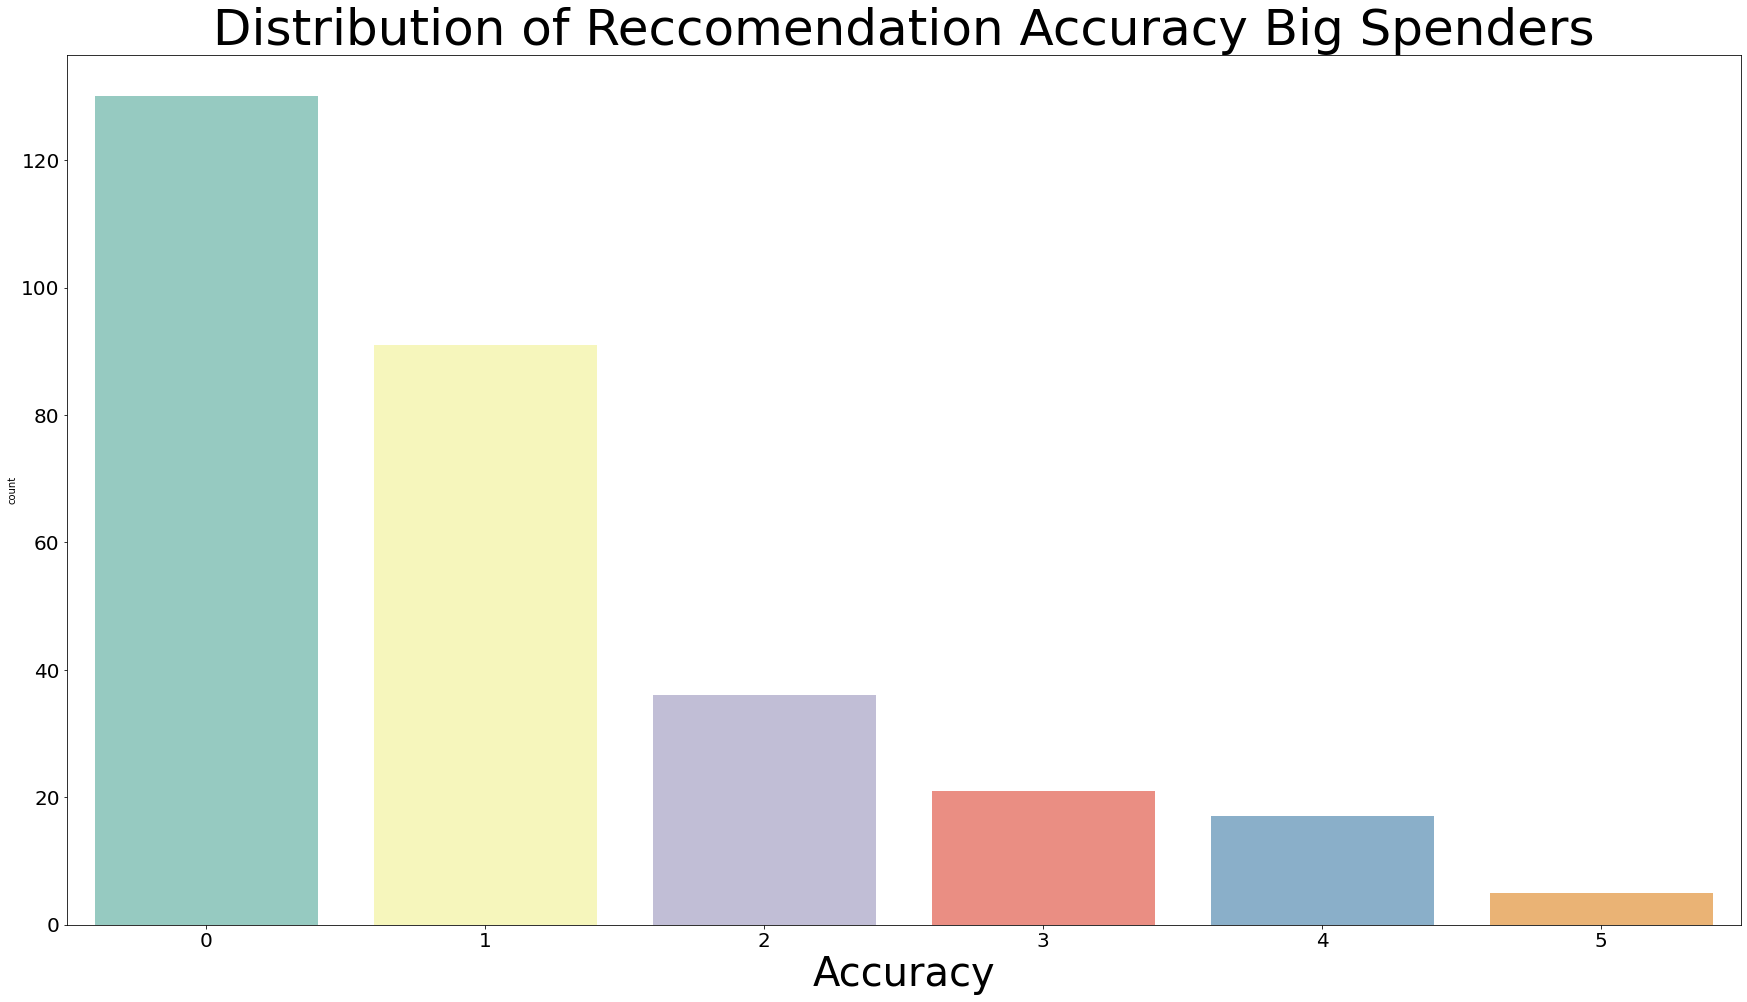

In [32]:

plt.figure(figsize=(30,16))

catcnt = sns.countplot(x="Accuracy", data=accurcies,palette="Set3")
catcnt.axes.set_title("Network Association Model Accuracy - Big Spenders",fontsize=50)
catcnt.set_xlabel("Accuracy",fontsize=40)
catcnt.tick_params(labelsize=30)

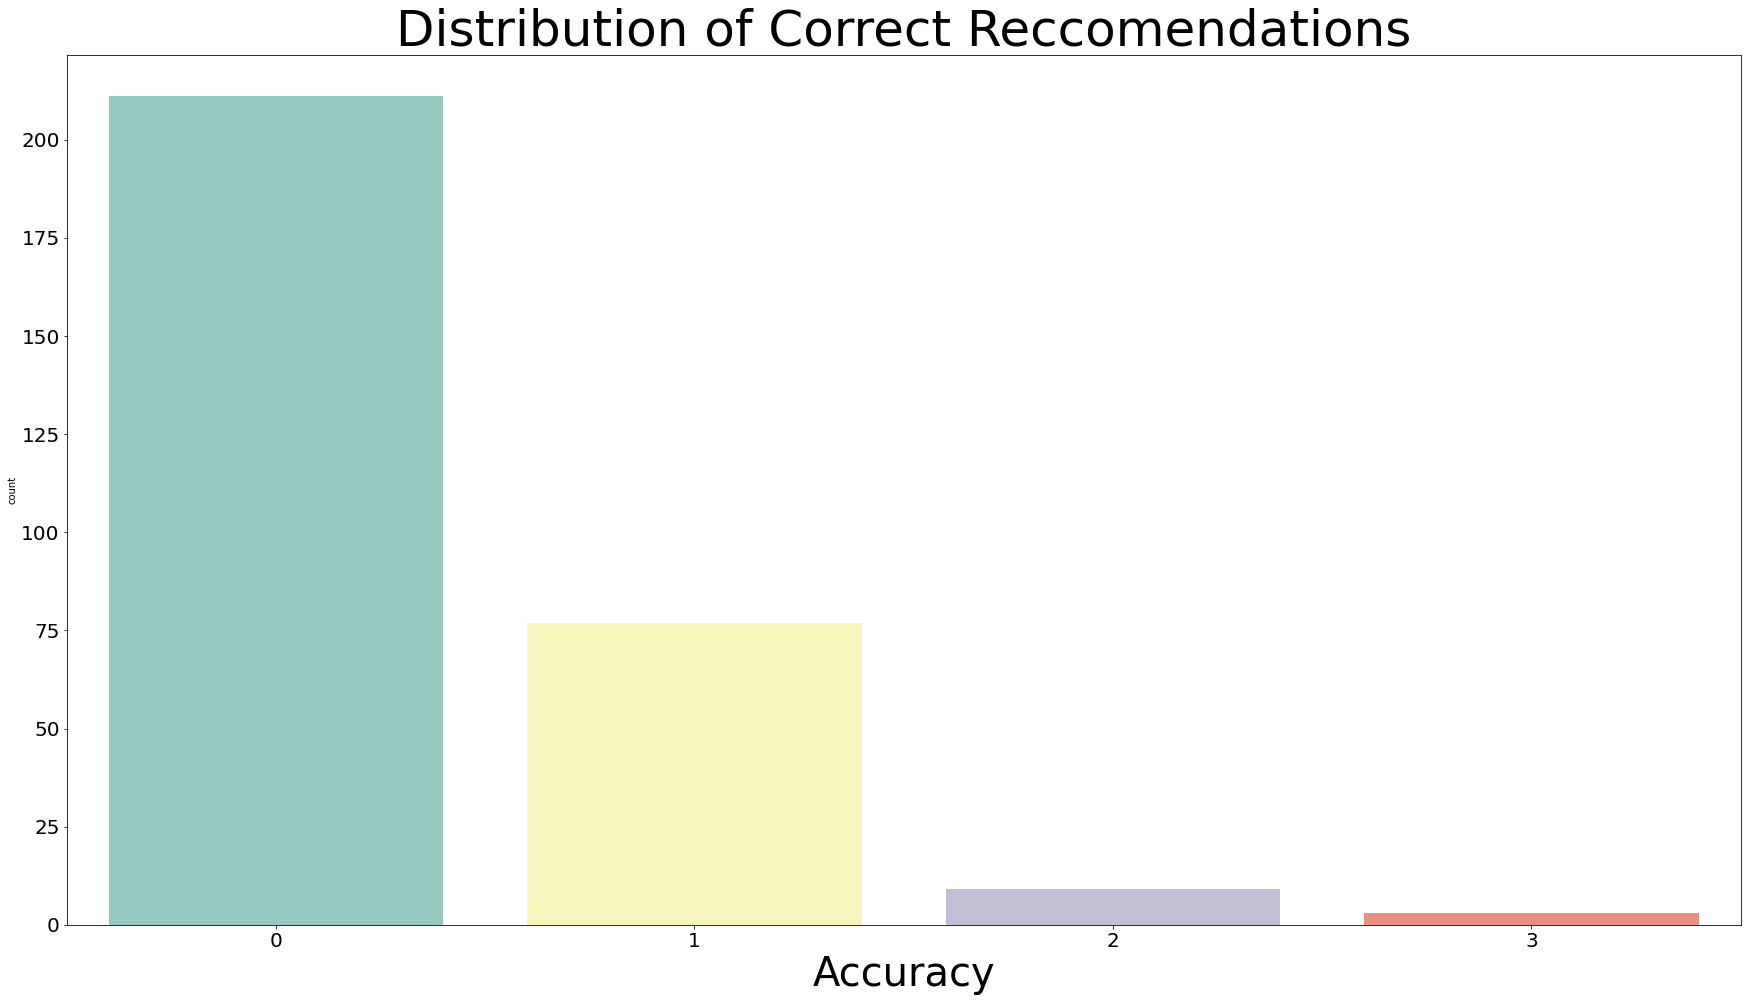

In [34]:
#random Sample

plt.figure(figsize=(30,16))
catcnt = sns.countplot(x="Accuracy", data=accurcies,palette="Set3")
catcnt.axes.set_title("Network Association Model",fontsize=50)
catcnt.set_xlabel("Accuracy",fontsize=40)
catcnt.tick_params(labelsize=30)

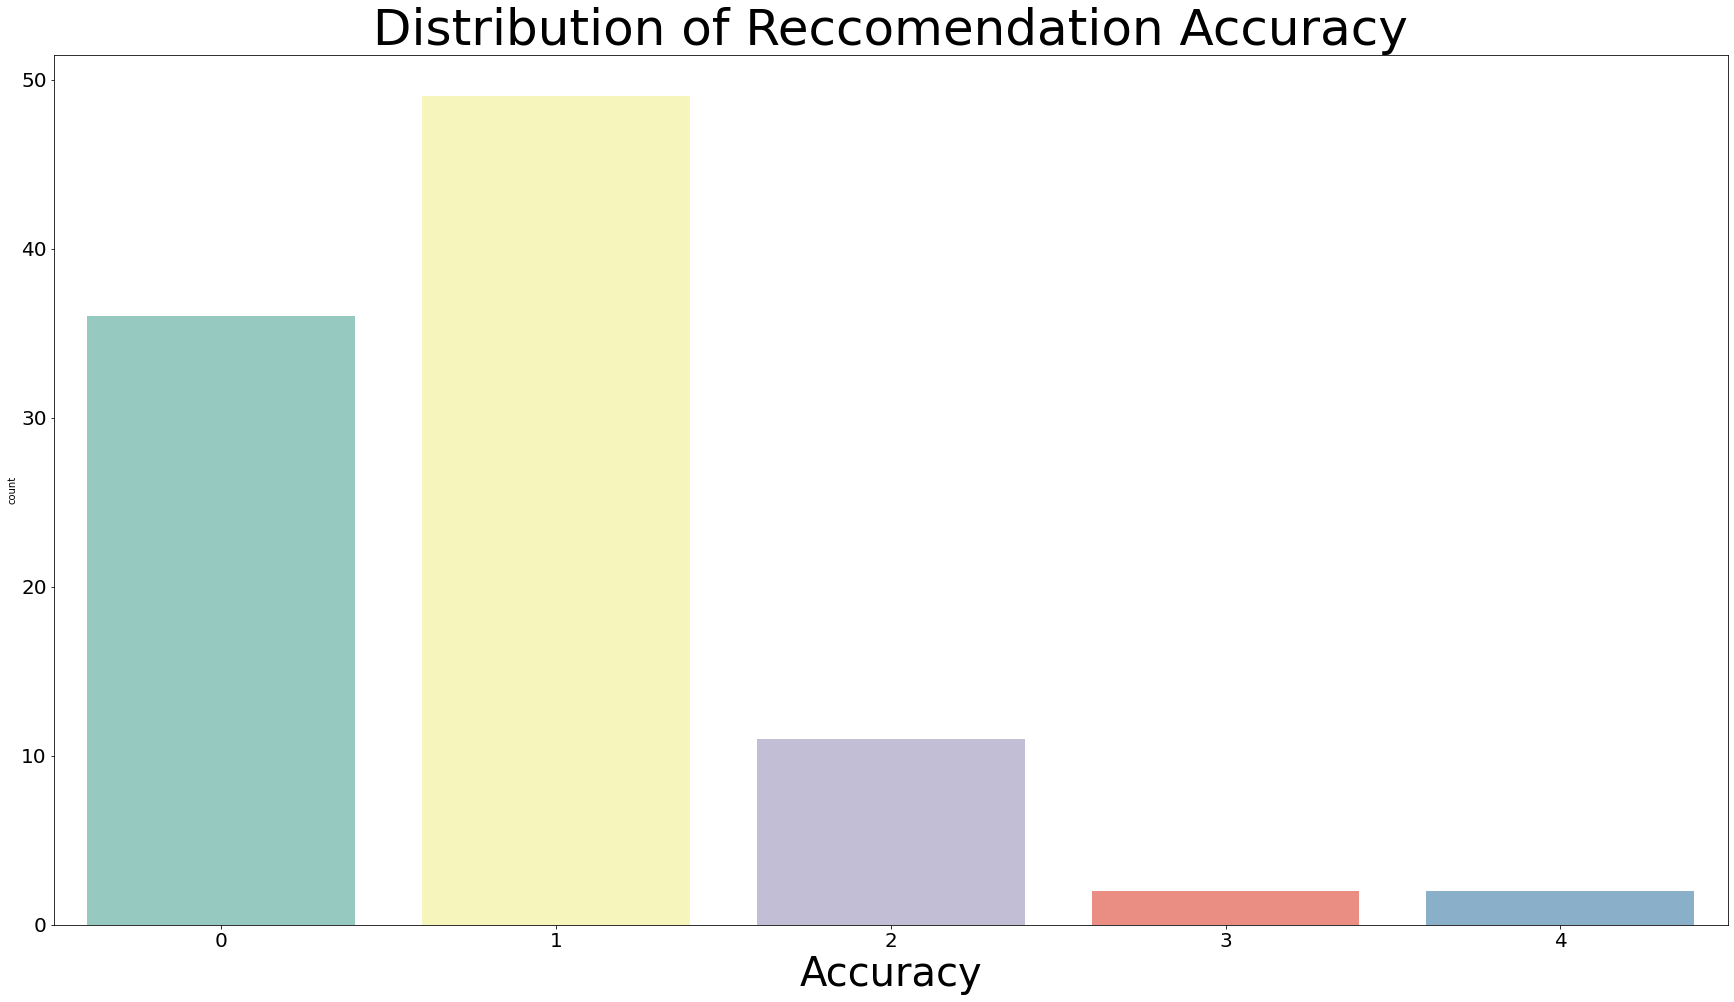

In [34]:
#dont do it !!!!!!!!!!!

#1/5 of the recommendation were correct

plt.figure(figsize=(30,16))
catcnt = sns.countplot(x="Accuracy", data=accurcies,palette="Set3")
catcnt.axes.set_title("Network Association Model Accuracy",fontsize=50)
catcnt.set_xlabel("Accuracy",fontsize=40)
catcnt.tick_params(labelsize=30)

In [26]:
VPU[VPU.END_USER_ID == '91E9E26442E3A4E7B5488EBFDC26361D'].Vendor.tolist()[0]

['7A07BB33C6152690B88E290F6914F5A6',
 '5808D4F4E2ADE1859D788181D740F940',
 'D1BB02DB9ADF9B17723CD24E386D2A0A',
 'C806100AD2B61B06FE232468006BB818',
 '95E74678F58D7F04BA7ACA2FBCD36899',
 '537D0927BE83035D12B4F138B192A42D',
 'E11016BBE46D7FF112A2B4D2F34776D1',
 '11CA995A4746A5BB9A6C08B284DC8DA0',
 'F36F01EAE744B9E28ABF24659DC7DA79',
 '28A33BABD6D657A6925C60432600CC41',
 '493E9B4830E95D425AD2A271F801A9C0',
 '75882919BE4A82D5B5BDB1E89337F8D7',
 '48F9B31AE84FE972B37744983BA8CC85',
 '2139487FDFE1D470BBE9E3DAAD4E0B84',
 'A4190183C76E071BEE5E74B2629C637F',
 '63184ABE8B9DBEC9633451AB0AF82CD0',
 '5EA70470CC3BE29F101604DCD8BCBB58',
 '1DE7ED54EC516EF1A869D7C979626837',
 '9CB097CF7F1B88DC3DDC1E6D31DBE1E2',
 '712AE3DC969805D8BE3EFF33E7FFD2CB',
 '27D31D02914E99DA80E46A8BF1E2847D',
 'F2B45F8B98594E33145427891846FFD1',
 'E026842D4C0FF8FC2E9BAFC677A678C4',
 'F03022F90F791A438D9EFE63A8BBCBF9',
 '0C57785D8C42250848C40BF95EA6B0EB',
 '76327AEA150629712A2E721275ABB632',
 '9464654FF656ECFB51EBC546748FEE8E',
 

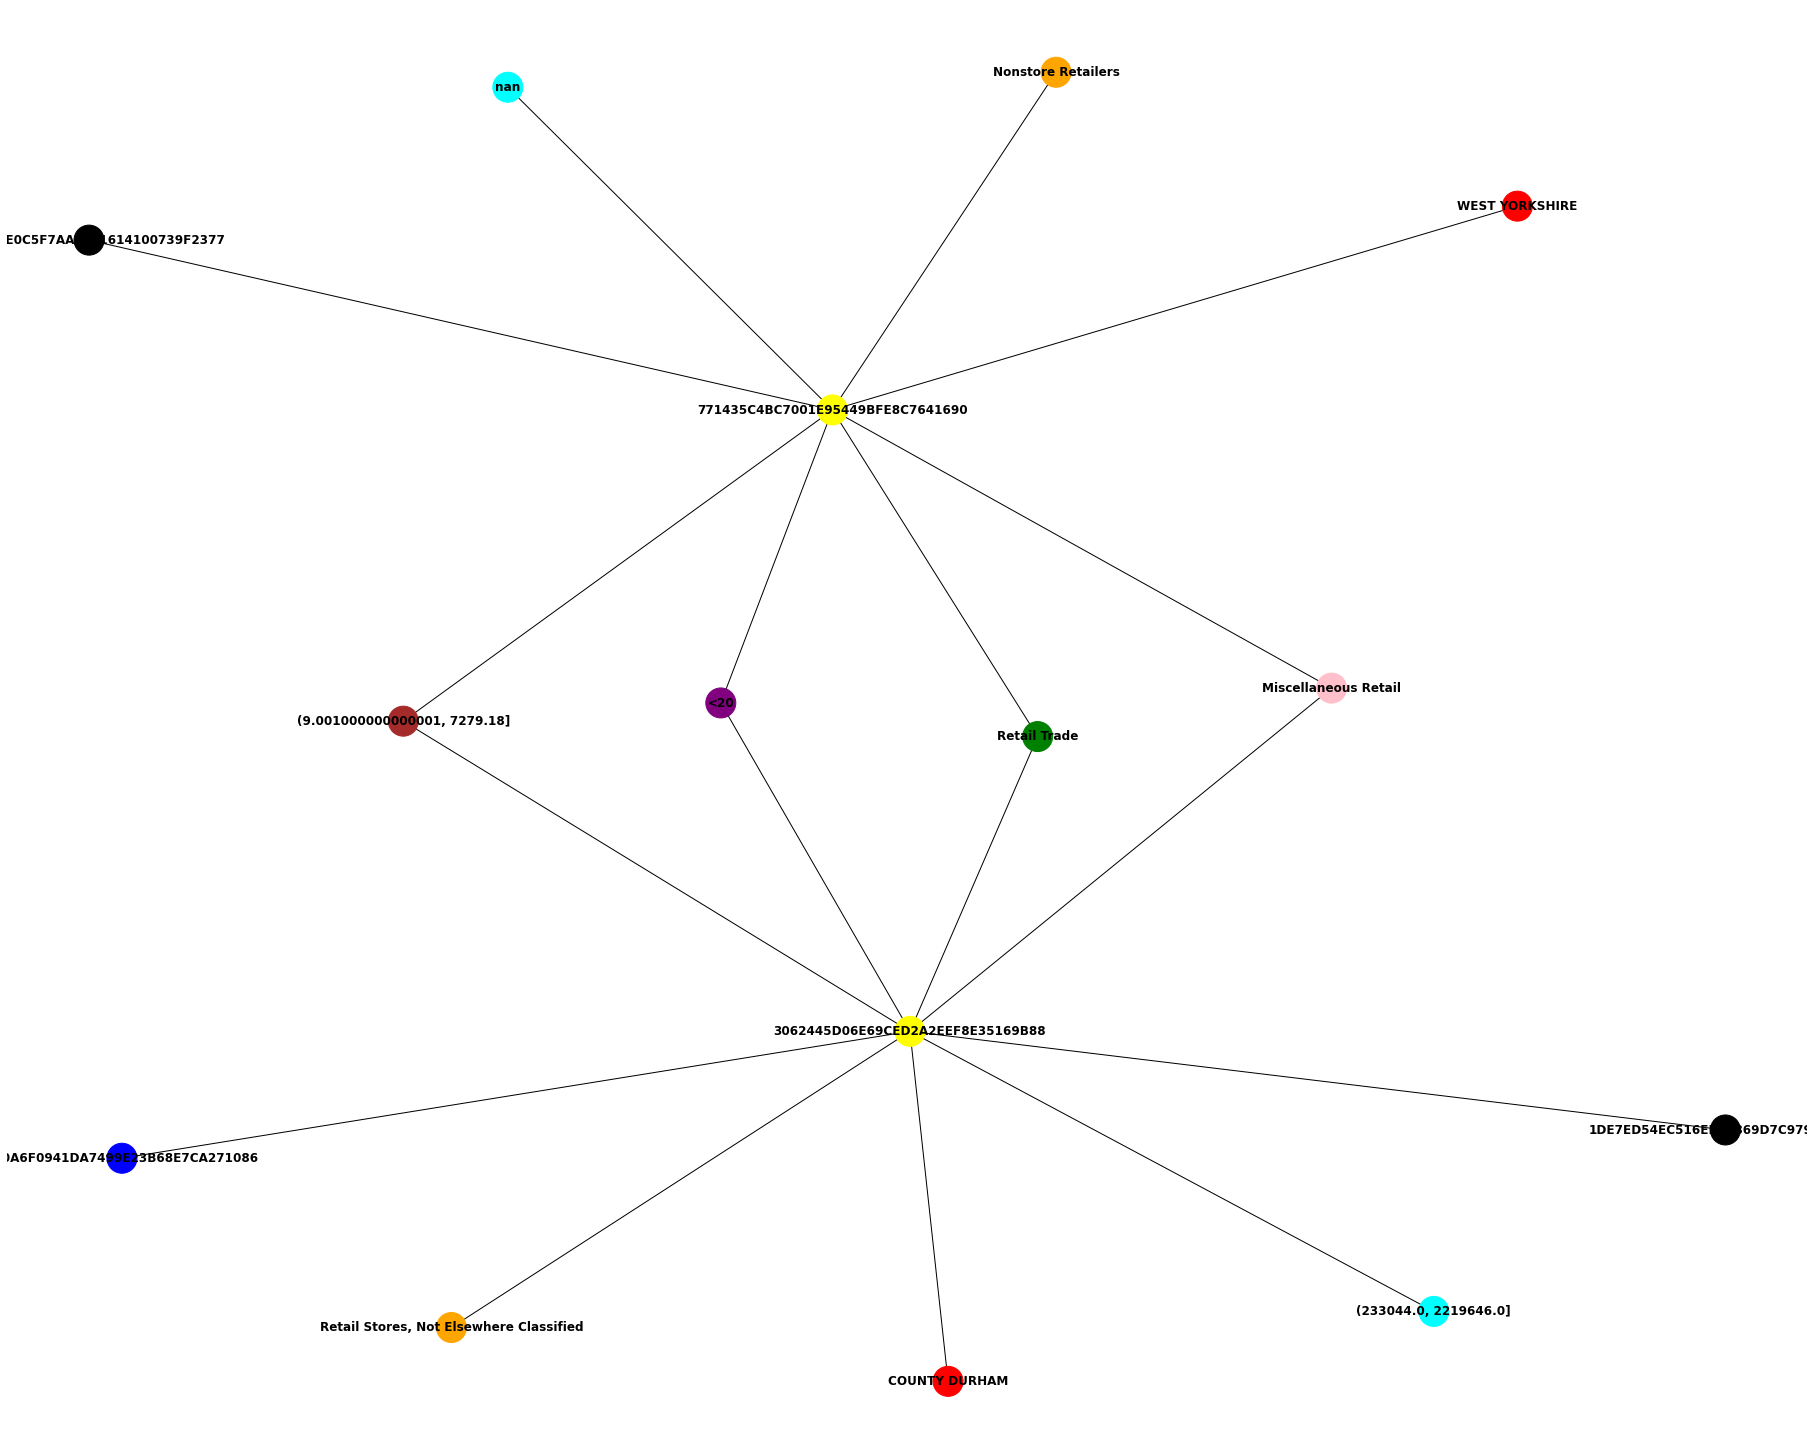

In [209]:
#plot network diagram by testing it with products to view similiarity patterns & what connects the two users together
#if cust in test set, we are assuming they didn't buy anything

list_in=["3062445D06E69CED2A2EEF8E35169B88",'771435C4BC7001E95449BFE8C7641690']
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

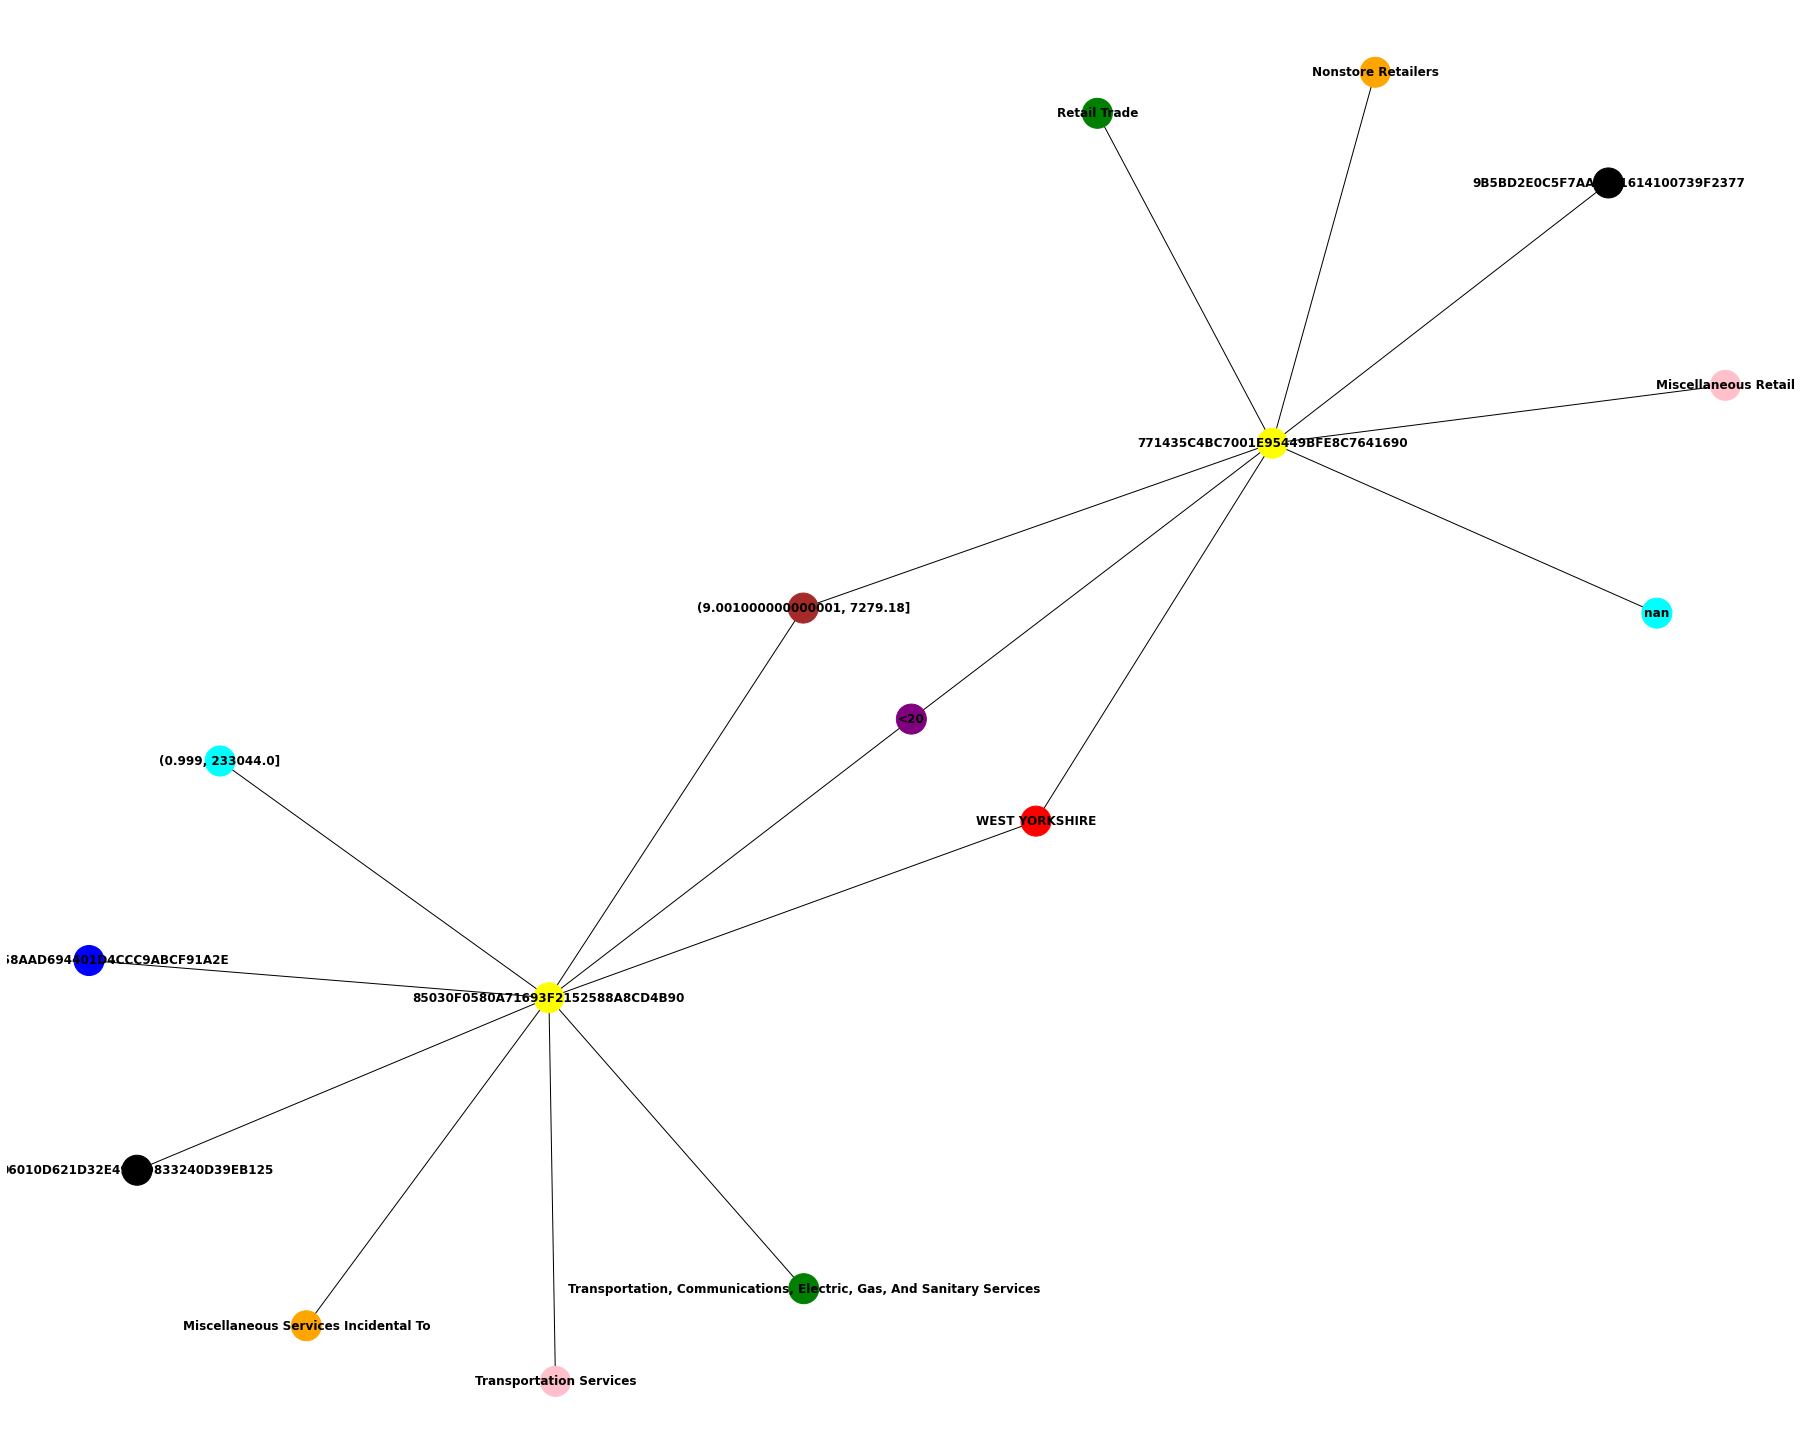

In [211]:
#plot another
list_in=["85030F0580A71693F2152588A8CD4B90","771435C4BC7001E95449BFE8C7641690"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

In [29]:
#look at customers that bought similiar products 
#get users 
#group by enduser
#add products that they bought: show one row per user 
#use EndUser and add everything we need to it: product id, total spent, vendor id, 

#get top 5 users, remove those items that they already bought, get accuracy
#if end user id in the list it will return products and remove all the current user bought already

#come up with rating system:



#replace products nodes that they prchased, replace with 0. Assume they didnt buy it before 

In [ ]:
1. sample
2. modify table
3. graph
4. compare results